# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Импорты

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import HTML, display
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    ParameterSampler,
    KFold
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    RobustScaler,
    FunctionTransformer
    )
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from scipy.stats import randint, uniform

from tqdm import tqdm
import time
import re
from rapidfuzz import fuzz, process
from phik import phik_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

# уберем лишние выводы при обучении моделей
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import logging
logging.getLogger("sklearn").setLevel(logging.ERROR)

import xgboost as xgb
xgb_params = {"verbosity": 0}


### Константы

In [45]:
# зафиксируем константы
RANDOM_STATE = 20
TEST_SIZE = 0.25
N_JOBS = -1
N_ITER = 10 # число итераций для перебора и поиска лучших параметров
N_CROSS_VALL = 3

# Функции для работы

In [46]:
# форматирования текста
def format_display(text):
    return HTML(f"<span style='font-size: 1.5em; font-weight: bold; font-style: italic;'>{text}</span>")

# сделаем функцию оценки пропусков в датасетах
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)

# функция для обработки пробелов
def process_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = ' '.join(s.split())
    return s

# замена пробелов на нижнее подчеркинвание в названии столбцов
def replace_spaces(s):
    if isinstance(s, str):
        s = s.strip()
        s = '_'.join(s.split())
    return s

def drop_duplicated(data):
    # проверка дубликатов
    display(format_display("Проверим дубликаты и удалим, если есть"))
    num_duplicates = data.duplicated().sum()
    display(num_duplicates)
    
    if num_duplicates > 0:
        display("Удаляем")
        data = data.drop_duplicates(keep='first').reset_index(drop=True)  # обновляем DataFrame
    else:
        display("Дубликаты отсутствуют")
    return data

def normalize_columns(columns):
    new_cols = []
    for col in columns:
        # вставляем "_" перед заглавной буквой (латиница или кириллица), кроме первой
        col = re.sub(r'(?<!^)(?=[A-ZА-ЯЁ])', '_', col)
        # приводим к нижнему регистру
        col = col.lower()
        new_cols.append(col)
    return new_cols

def check_data(data):
    # приведем все к нижнему регистру
    data.columns = normalize_columns(data.columns)
    
    # удалим лишние пробелы в строках
    data = data.map(process_spaces)

    # и в названии столбцов
    data.columns = [replace_spaces(col) for col in data.columns]
    
    # общая информация 
    display(format_display("Общая информация базы данных"))
    display(data.info())
    
    # 5 строк
    display(format_display("5 случайных строк"))
    display(data.sample(5))
    
    # пропуски
    display(format_display("Число пропусков в базе данных"))
    display(missing_data(data))

    # проверка на наличие пропусков
    if data.isnull().sum().sum() > 0:
        display(format_display("Визуализация пропусков"))
        msno.bar(data)
        plt.show()
        
    # средние характеристики
    display(format_display("Характеристики базы данных"))
    display(data.describe().T)
    
    data = drop_duplicated(data)
    
    return data  # возвращаем измененные данные

def plot_combined(data, col=None, target=None, col_type=None, legend_loc='best'):
    """
    Строит графики для числовых столбцов в DataFrame, автоматически определяя их типы (дискретные или непрерывные).

    :param data: DataFrame, содержащий данные для визуализации.
    :param col: Список столбцов для построения графиков. Если None, будут использованы все числовые столбцы.
    :param target: Столбец, по которому будет производиться разделение (для hue в графиках).
    :param col_type: Словарь, определяющий типы столбцов ('col' для непрерывных и 'dis' для дискретных).
                     Если None, типы будут определены автоматически.
    :param legend_loc: Положение легенды для графиков (по умолчанию 'best').
    :return: None. Графики отображаются с помощью plt.show().
    """
    
    # Определяем числовые столбцы
    if col is None:
        numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    else:
        numerical_columns = col

    # Если col_type не указан, определяем типы автоматически
    if col_type is None:
        col_type = {}
        for col in numerical_columns:
            unique_count = data[col].nunique()
            if unique_count > 20:
                col_type[col] = 'col'  # Непрерывные данные
            else:
                col_type[col] = 'dis'  # Дискретные данные

    total_plots = len(numerical_columns) * 2
    ncols = 2
    nrows = (total_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axs = axs.flatten()

    index = 0

    for col in numerical_columns:
        # Определяем тип графика
        plot_type = col_type.get(col)
        if plot_type is None:
            raise ValueError(f"Тип для столбца '{col}' не указан в col_type.")

        # Гистограмма или countplot
        if index < len(axs):
            if plot_type == 'col':
                if target is not None:
                    sns.histplot(data, x=col, hue=target, bins=20, kde=True, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.histplot(data[col].dropna(), bins=20, kde=True, ax=axs[index])
                axs[index].set_title(f'Гистограмма: {col}')
            elif plot_type == 'dis':
                if target is not None:
                    sns.countplot(data=data, x=col, hue=target, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.countplot(data=data, x=col, ax=axs[index])
                axs[index].set_title(f'Countplot: {col}')
                # поворот подписей X для дискретных
                axs[index].tick_params(axis='x', rotation=90)
            index += 1

        # Боксплот
        if index < len(axs):
            sns.boxplot(x=data[col], ax=axs[index])
            axs[index].set_title(f'Боксплот: {col}')
            # тоже поворачиваем, если дискретные значения
            if plot_type == 'dis':
                axs[index].tick_params(axis='x', rotation=90)
            index += 1

    # Отключаем оставшиеся оси
    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_categorical_columns(data, col=None, target=None, top_n=None):
    """
    Визуализация категориальных столбцов: только столбчатые графики (с группировкой по target).
    top_n — показывать только top_n категорий, остальные сворачивать в 'other'.
    """
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

    if col is not None:
        if col not in data.columns:
            print(f"Столбец '{col}' не найден в DataFrame.")
            return
        categorical_columns = [col]

    if len(categorical_columns) == 0:
        print("Категориальных столбцов нет.")
        return

    n = len(categorical_columns)
    ncols = 2
    nrows = (n + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    if isinstance(axs, np.ndarray):
        axs = axs.flatten()
    else:
        axs = [axs]

    idx = 0
    for c in categorical_columns:
        # value_counts с NaN
        vc = data[c].fillna('NaN').value_counts()

        if top_n is not None and len(vc) > top_n:
            head = vc.iloc[:top_n].copy()
            rest = vc.iloc[top_n:].sum()
            head['other'] = rest
            vc = head

        labels = vc.index.tolist()
        cmap = plt.colormaps.get_cmap('tab20').resampled(max(1, len(labels)))
        colors = [cmap(i) for i in range(len(labels))]

        if target is not None and target in data.columns:
            grouped = data.groupby([target, c]).size().unstack(fill_value=0)
            cmap2 = plt.cm.get_cmap('tab20', max(1, len(grouped.columns)))
            bar_colors = [cmap2(i) for i in range(len(grouped.columns))]
            grouped.plot(kind='bar', ax=axs[idx], color=bar_colors)
            axs[idx].legend(title=target)
        else:
            vc.plot(kind='bar', ax=axs[idx], color=colors)

        axs[idx].set_title(f'{c} (гистограмма)')
        axs[idx].set_ylabel('Частота')
        axs[idx].tick_params(axis='x', rotation=90)
        idx += 1

    for j in range(idx, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def analyze_data(dataframes, drop_columns):
    """
    Анализирует данные, удаляет указанные столбцы и строит графики распределения
    для общих числовых столбцов.

    :param dataframes: Список баз данных (списки pandas DataFrame)
    :param drop_columns: Список столбцов для удаления (список строк)
    """

    cleaned_data = [df.drop(columns=drop_columns, errors='ignore') for df in dataframes]
    
    # Находим общие числовые столбцы
    common_columns = set(cleaned_data[0].select_dtypes(include=['float64', 'int64']).columns)
    for df in cleaned_data[1:]:
        common_columns.intersection_update(df.select_dtypes(include=['float64', 'int64']).columns)

    if not common_columns:
        print("Нет общих числовых столбцов для анализа.")
        return

    # Преобразуем множество в список
    common_columns = list(common_columns)

    combined_data = pd.concat(
        [df[common_columns].assign(dataset=f'base_{i+1}') for i, df in enumerate(cleaned_data)],
        keys=[f'base_{i+1}' for i in range(len(cleaned_data))],
        names=['dataset', 'index']
    )

    palette = {f'base_{i+1}': 'blue' if i == 0 else 'orange' for i in range(len(cleaned_data))}
    
    for column in common_columns:
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data=combined_data, x=column, hue='dataset', common_norm=False, fill=True, palette=palette)
        plt.title(f'Распределение {column}')
        plt.xlabel(column)
        plt.ylabel('Плотность')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles:
            plt.legend(title='Набор данных', loc='best', labels=[f'Таблица {label}' for label in labels])
        
        plt.show()
        
def calc_target_correlations(df, target_col: str = None, drop_cols: list = None): # type: ignore
    """
    Считает корреляции признаков с таргетом, строит heatmap и рассчитывает VIF.
    """
    if drop_cols is None:
        drop_cols = []
    
    df_tmp = df.copy()

    # Преобразуем категориальные в числовые
    cat_cols = df_tmp.select_dtypes(include=["object", "category"]).columns
    for c in cat_cols:
        df_tmp[c] = df_tmp[c].astype("category").cat.codes

    # Числовые колонки
    numeric_cols = df_tmp.select_dtypes(exclude=["object", "category"]).columns.tolist()
    if target_col not in numeric_cols:
        raise ValueError(f"target_col '{target_col}' должен быть числовым")

    # Корреляции с target
    corr_df = (
        df_tmp[numeric_cols]
        .corr()[target_col]
        .drop(target_col)
        .sort_values(key=np.abs, ascending=False)
    )
    display("=== Корреляция с таргетом ===")
    display(corr_df)

    # Heatmap
    heatmap_cols = [col for col in numeric_cols if col not in drop_cols or col == target_col]
    corr_matrix = df_tmp[heatmap_cols].corr()

    plt.figure(figsize=(12, 10))
    plt.imshow(corr_matrix, interpolation="nearest", cmap="coolwarm", aspect="auto")
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=8)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=8)
    plt.colorbar()
    plt.title("Correlation Heatmap (включая target)")

    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            value = corr_matrix.iloc[i, j]
            plt.text(j, i, f"{value:.2f}", ha="center", va="center", fontsize=6, color="black")

    plt.tight_layout()
    plt.show()

    # VIF
    vif_cols = [col for col in numeric_cols if col != target_col and col not in drop_cols]
    X_vif = df_tmp[vif_cols].copy()
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_vif), columns=vif_cols)

    vif_data = pd.DataFrame()
    vif_data["feature"] = vif_cols
    vif_data["VIF"] = [
        variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])
    ]
    vif_data = vif_data.sort_values("VIF", ascending=False)

    display("=== VIF ===")
    display(vif_data)

# Анализ данных

## Подключим и почитаем базу

In [47]:
df = pd.read_csv("autos.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

None

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
155513,2016-04-02 21:54:36,1500,wagon,2000,auto,170,e_klasse,150000,1,gasoline,mercedes_benz,no,2016-04-02 00:00:00,0,57076,2016-04-02 22:44:26
150836,2016-03-12 07:56:06,3000,sedan,1985,auto,90,NaN,70000,1,petrol,opel,no,2016-03-12 00:00:00,0,21357,2016-03-31 06:45:19
240356,2016-03-18 09:41:53,1900,NaN,2017,manual,0,NaN,150000,1,petrol,volkswagen,NaN,2016-03-18 00:00:00,0,19288,2016-03-18 09:41:53
302082,2016-03-09 19:46:17,1450,sedan,2000,manual,90,a_klasse,150000,7,gasoline,mercedes_benz,no,2016-03-09 00:00:00,0,89077,2016-03-10 05:46:06
277202,2016-03-12 11:58:56,2200,small,2005,manual,80,NaN,125000,4,petrol,ford,no,2016-03-12 00:00:00,0,15526,2016-03-13 03:45:24


vehicle_type    37490
gearbox         19833
model           19705
fuel_type       32895
repaired        71154
dtype: int64

None

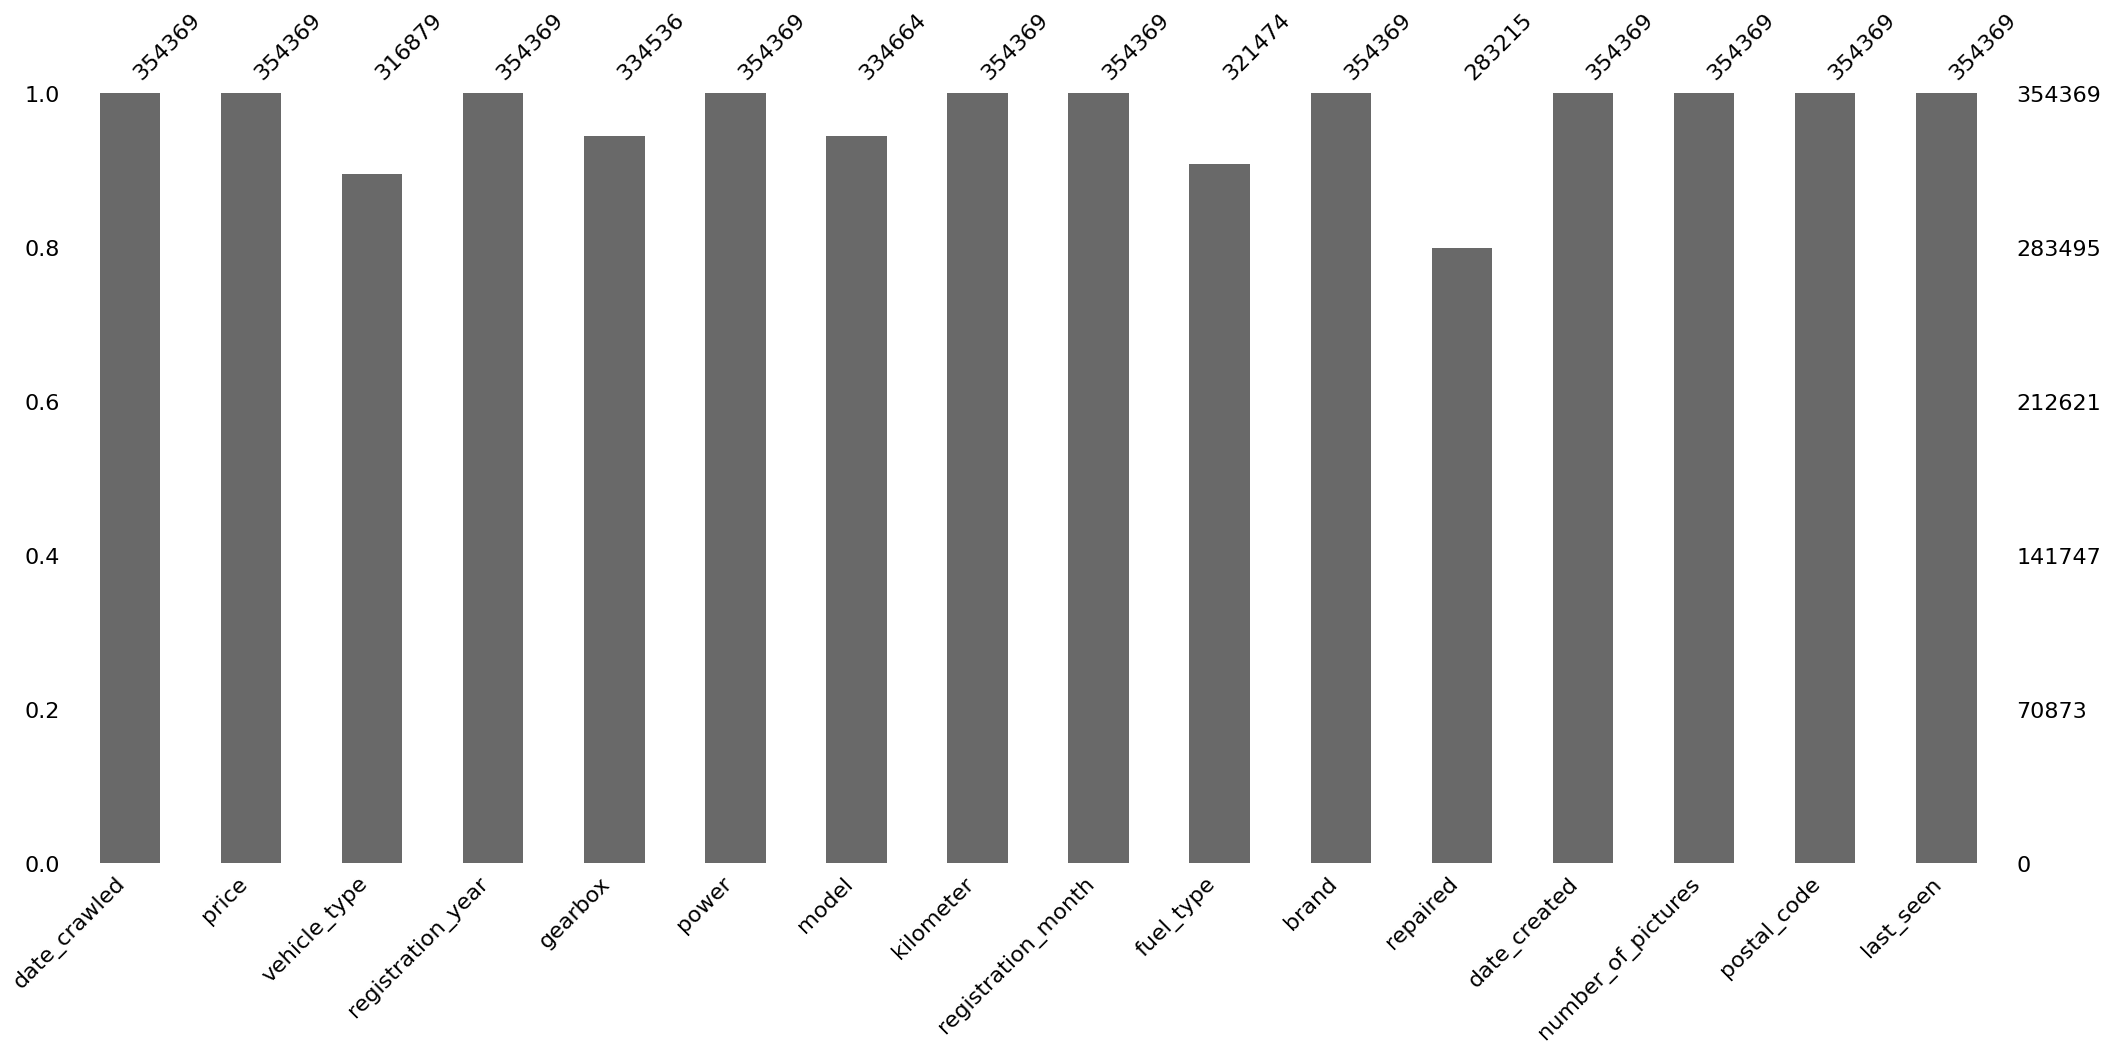

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


np.int64(4)

'Удаляем'

In [48]:
df = check_data(df)

## Описание данных

Признаки:  
DateCrawled — дата скачивания анкеты из базы - не влияет на цену  
VehicleType — тип автомобильного кузова - влияет  
RegistrationYear — год регистрации автомобиля - влияет, вероятнее всего имелся год ввода в эксплуатацию  
Gearbox — тип коробки передач - влияет  
Power — мощность (л. с.) - влияет  
Model — модель автомобиля - влияет  
Kilometer — пробег (км) - влияет  
RegistrationMonth — месяц регистрации автомобиля - не влияет
FuelType — тип топлива - влияет  
Brand — марка автомобиля - влияет  
Repaired — была машина в ремонте или нет - влияет  
DateCreated — дата создания анкеты - не влияет  
NumberOfPictures — количество фотографий автомобиля - не влияет  
PostalCode — почтовый индекс владельца анкеты (пользователя) - не влияет  
LastSeen — дата последней активности пользователя - не влияет  

Целевой признак  
Price — цена (евро)

In [49]:
# DateCrawled не влияет, но покажет на границы выборки по году регистрации, проверим
np.sort(df["date_crawled"].unique())

array(['2016-03-05 14:06:22', '2016-03-05 14:06:23',
       '2016-03-05 14:06:24', ..., '2016-04-07 14:36:55',
       '2016-04-07 14:36:56', '2016-04-07 14:36:58'],
      shape=(271174,), dtype=object)

Значит авто моложе 2016 года у нас не будет в выборке. Запомнили.

## Оставим влияющие на цену признаки

In [50]:
# таким образом оставим только нужные нам признаки
need_cols = ["price", "vehicle_type", "registration_year", "gearbox", "power", "model", "kilometer", "fuel_type", "brand", "repaired"]
df = df[need_cols]

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       316875 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            334532 non-null  object
 4   power              354365 non-null  int64 
 5   model              334660 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          321470 non-null  object
 8   brand              354365 non-null  object
 9   repaired           283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [52]:
missing_data(df)

vehicle_type    37490
gearbox         19833
model           19705
fuel_type       32895
repaired        71154
dtype: int64

## Анализ данных

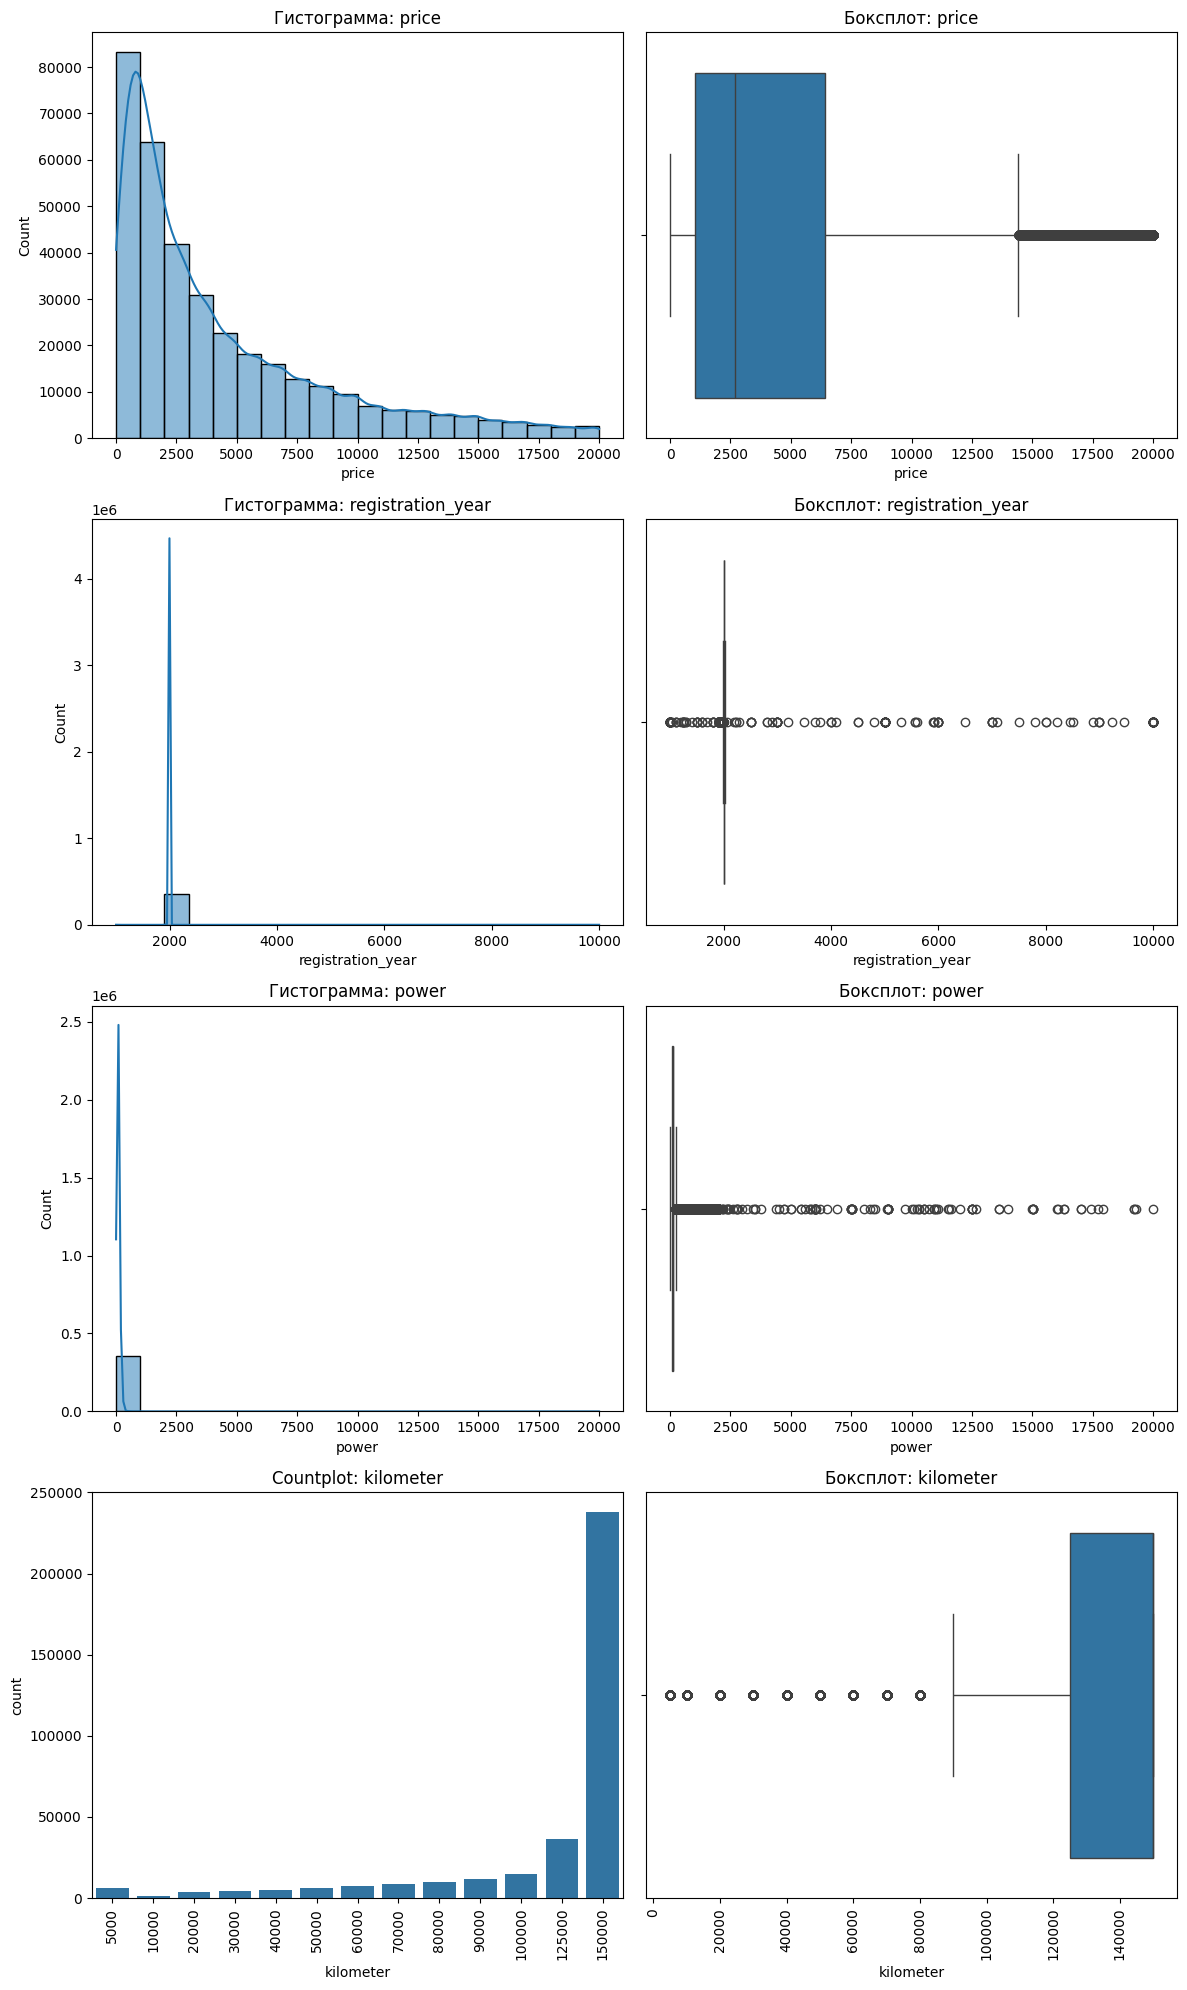

In [53]:
# вначале посмотрим что там с непрерывными данными
plot_combined(df, col=None, target=None, col_type=None, legend_loc='best')

В целом только цена и пробег выглядят адекватно, но все равно изучим детальнее

In [54]:
custom_percentiles = [0.05, 0.15, 0.55, 0.95, 0.99]

In [55]:
# посмотрим на цену
display(df["price"].describe(percentiles=custom_percentiles))

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
5%          200.000000
15%         650.000000
50%        2700.000000
55%        3200.000000
95%       14600.000000
99%       18800.000000
max       20000.000000
Name: price, dtype: float64

In [56]:
# что там у нас такое дорогое?
display(df[df["price"] > 14600])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no
33,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no
50,14800,convertible,2008,manual,170,1er,125000,petrol,bmw,NaN
64,14999,convertible,2007,manual,218,3er,50000,petrol,bmw,no
...,...,...,...,...,...,...,...,...,...,...
354255,15000,sedan,2013,auto,115,focus,60000,gasoline,ford,no
354275,16500,suv,2013,manual,116,i_reihe,30000,gasoline,hyundai,no
354282,16500,coupe,1973,manual,200,other,150000,petrol,bmw,yes
354302,16999,wagon,2008,auto,269,a6,150000,gasoline,audi,no


Гольф, сид, куга, фабия... явно не стоит таких денег - удаляем все что больше 14600

In [57]:
# а бесплатное?
display(df[df["price"] < 1])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354201,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354234,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354244,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354273,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


в целом, можно удалить все, что ниже наших 30к, т.е. < 300 евро

In [58]:
# посмотрим на дату регистрации
np.sort(df["registration_year"].unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Кто-то явно заполнял данные "от балды"  
Адекватный минимум, что я вижу 1960  
Максимум - 2016 год, согласно данным о выгрузке анкет   
Все, что не попадает - удалим

На август 2025 флагманом считается Gemera шведского производителя Koenigsegg с мощностью 2300 лошадиных сил  
0,75 л. с. — мощность первого автомобиля, созданного Карлом Бенцем, — Benz Patent Motorwagen

In [59]:
# ну и на всякий случай посмотрим, что у нас там на столько мощного в базе и не очень мощного
display(df[df["power"] > 400])
display(df[df["power"] < 30])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,NaN,1799,vectra,150000,petrol,opel,yes
2781,19500,suv,2004,auto,450,cayenne,125000,petrol,porsche,no
3289,16899,wagon,2003,auto,476,e_klasse,150000,petrol,mercedes_benz,no
3746,0,NaN,2017,manual,750,NaN,150000,petrol,smart,no
...,...,...,...,...,...,...,...,...,...,...
353489,12500,NaN,2017,manual,2000,other,60000,gasoline,chrysler,no
353629,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN
354041,20000,coupe,2006,auto,476,other,125000,petrol,mercedes_benz,no
354256,399,other,1994,NaN,1103,3er,150000,NaN,bmw,NaN


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
354342,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354356,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
354359,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354360,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes


Матизы, астры, корсы, зафиры... с казахами все понятно :)  
Опелеводы то куда так завышают мощность своих авто?  

In [60]:
display(df["power"].describe(percentiles=custom_percentiles))

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
5%            0.000000
15%          54.000000
50%         105.000000
55%         110.000000
95%         218.000000
99%         300.000000
max       20000.000000
Name: power, dtype: float64

Что и требовалось доказать - скорректируем предыдущие выводы.  
Все что меньше 54 и больше 300 удаляем

In [61]:
# и пробег
display(df["kilometer"].describe(percentiles=custom_percentiles))

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
5%        40000.000000
15%       80000.000000
50%      150000.000000
55%      150000.000000
95%      150000.000000
99%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

ну тут вроде все нормально  
врятли конечно же потолок всего 150к км будет на реальном сайте с тачками, но, что есть, то есть

In [62]:
# сказано - сделано
now_year = datetime.now().year
df = df[
    (df["registration_year"].between(1960, now_year)) &
    (df["price"].between(300, 14600)) &
    (df["power"].between(54, 300))
]

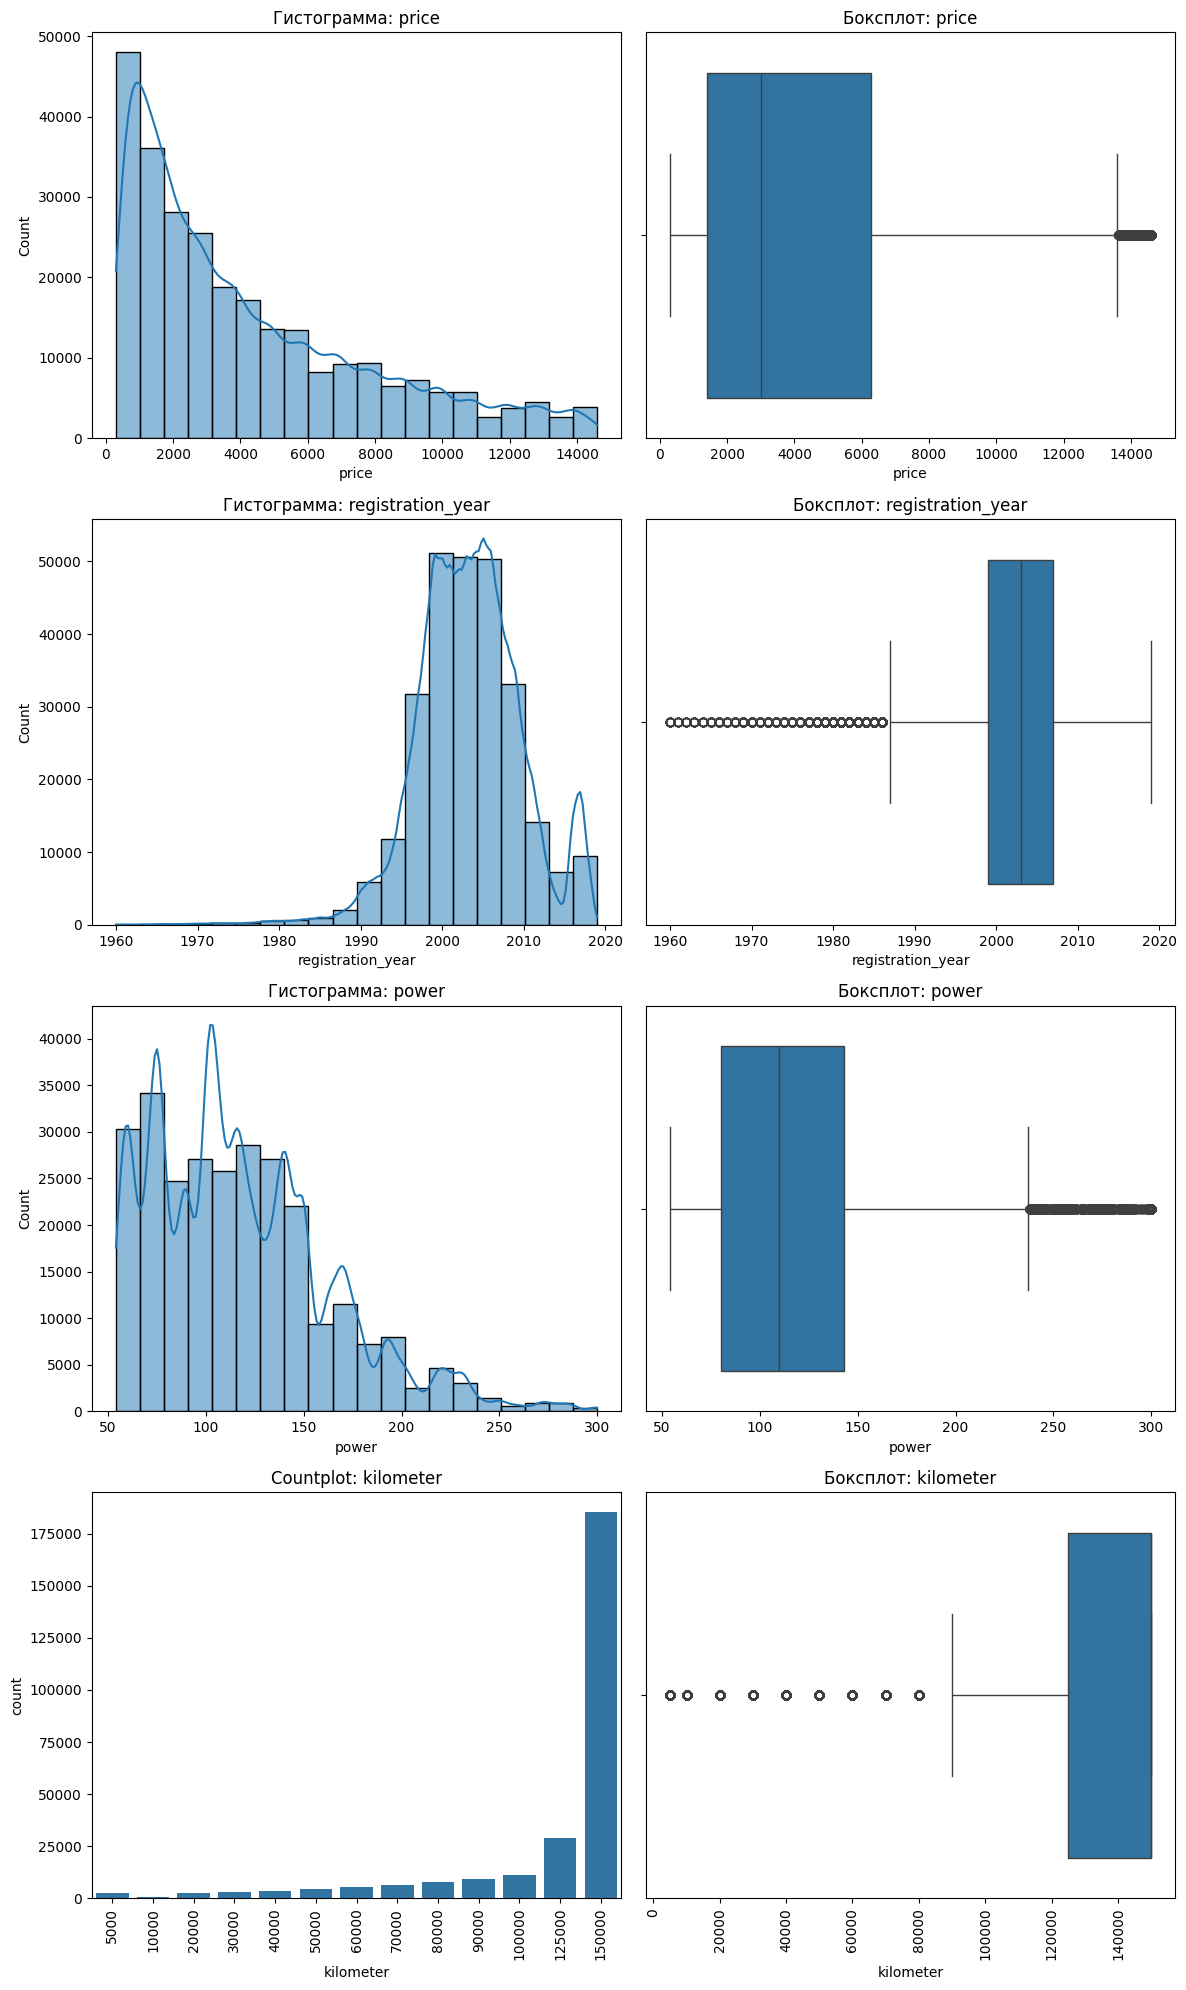

In [63]:
plot_combined(df, col=None, target=None, col_type=None, legend_loc='best')

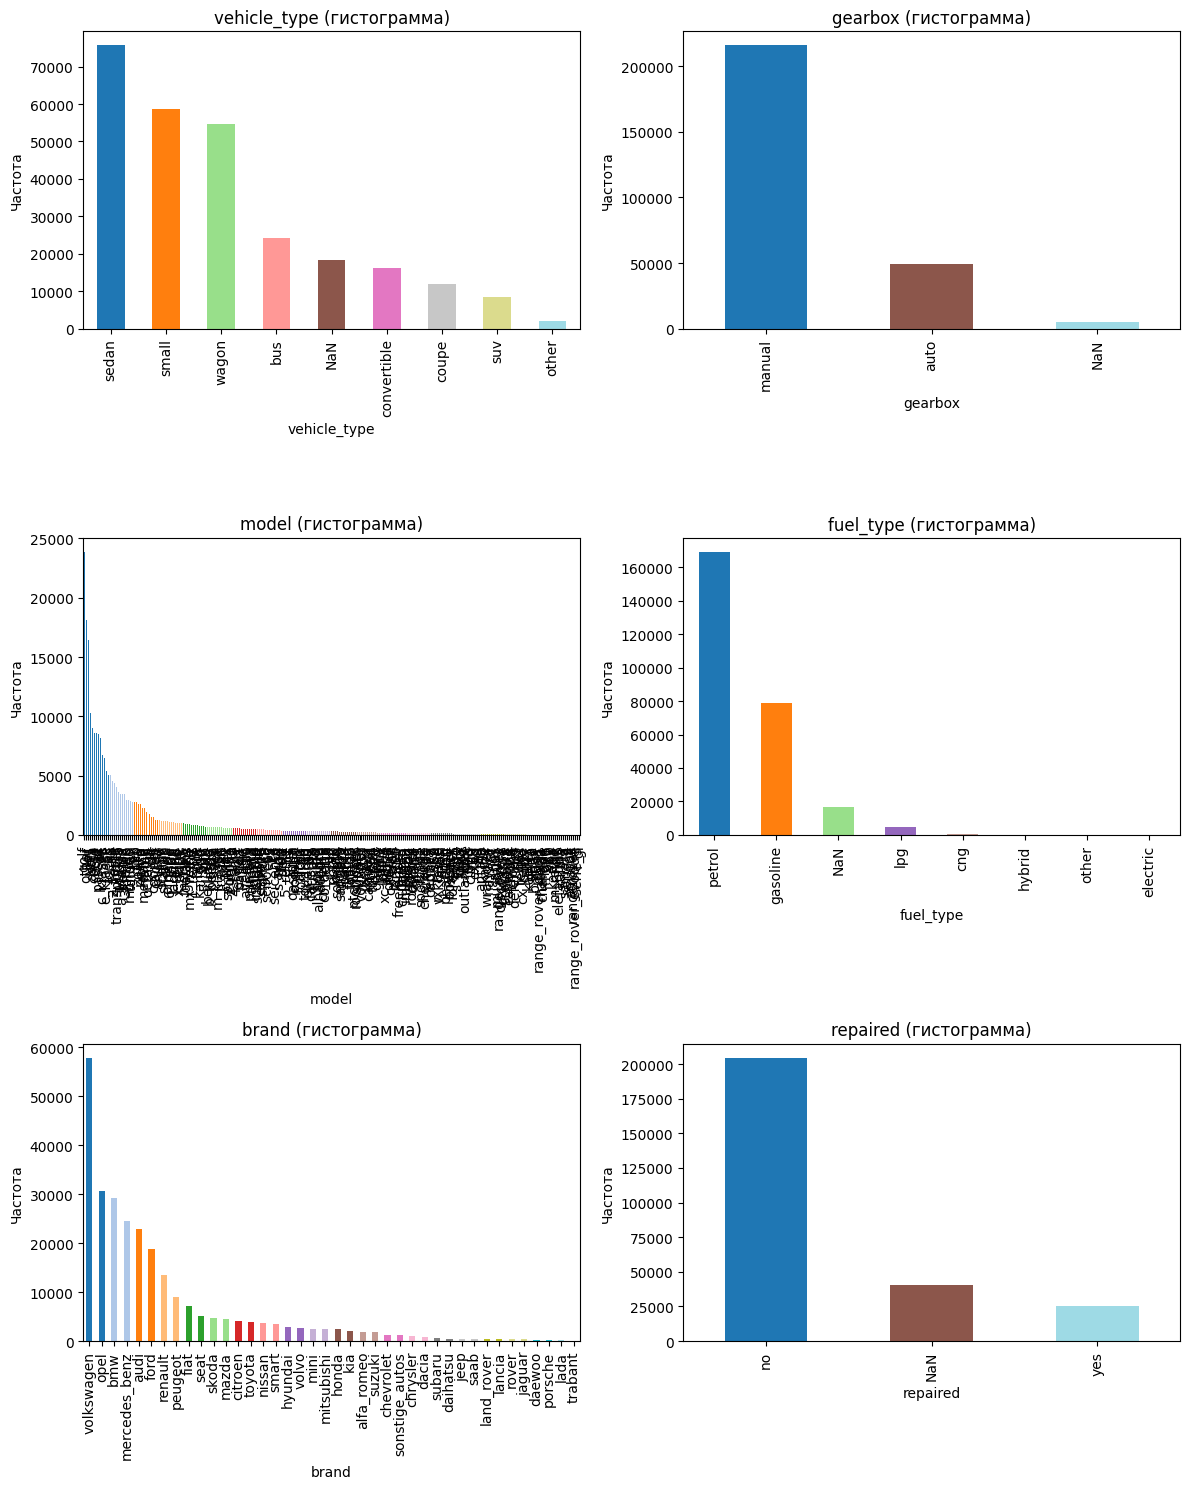

In [64]:
plot_categorical_columns(df, col=None, target=None)

Придется разобраться в моделях и брендах более детально  
Слишком всего много, возможно, есть ошибки/неявные дубли и т.д. и т.п.  

Тип кузова, тип топлива - есть и NaN и other... заменим NaN на unknown  
petrol = gasoline, оставим только gasoline

In [65]:
# модели
display(df["model"].nunique())
display(np.sort(df["model"].dropna().astype(str).unique()))

248

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000',
       '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse',
       'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok',
       'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo',
       'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster',
       'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max',
       'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival',
       'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic',
       'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper',
       'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire',
       'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo',
       'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort',
       'espace', 'ex

Как будто бы все выглядяит неплохо, среди того списка, что получилось вывести на экран.  
Но голос в моей голове говорит, что это не так - психанем немножко :)

In [66]:
unique_models = df["model"].dropna().astype(str).unique()
unique_models = sorted(unique_models)

similar_pairs = []

for i in range(len(unique_models)):
    for j in range(i+1, len(unique_models)):
        score = fuzz.ratio(unique_models[i], unique_models[j])
        if score >= 95:
            similar_pairs.append((unique_models[i], unique_models[j], score))

similar_df = pd.DataFrame(similar_pairs, columns=["Value1", "Value2", "Similarity"])
display(similar_df.sort_values(by="Similarity", ascending=False))


,Value1,Value2,Similarity
0,range_rover,rangerover,95.238095


голос был прав, есть косячок-с с британцами

<div class="alert alert-info">
Комментарий_itter_1<br>
+
</div>

In [67]:
# бренды
display(df["brand"].nunique())
display(np.sort(df["brand"].dropna().astype(str).unique()))

40

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

О как!  
sonstige_autos - перешли на немецкий язык описания "других" автомобилей :)  
Сделаем как other, для единообразия

In [68]:
# делаем
df["vehicle_type"] = df["vehicle_type"].fillna("unknown")
df["fuel_type"] = df["fuel_type"].fillna("unknown")
df["model"] = df["model"].fillna("unknown")
df["gearbox"] = df["gearbox"].fillna("unknown")
df["repaired"] = df["repaired"].fillna("unknown")

df.loc[(df["brand"] == "sonstige_autos"), "brand"] = "other"
df.loc[df["model"] == "rangerover", "model"] = "range_rover"
df.loc[df["fuel_type"] == "petrol", "fuel_type"] = "gasoline"

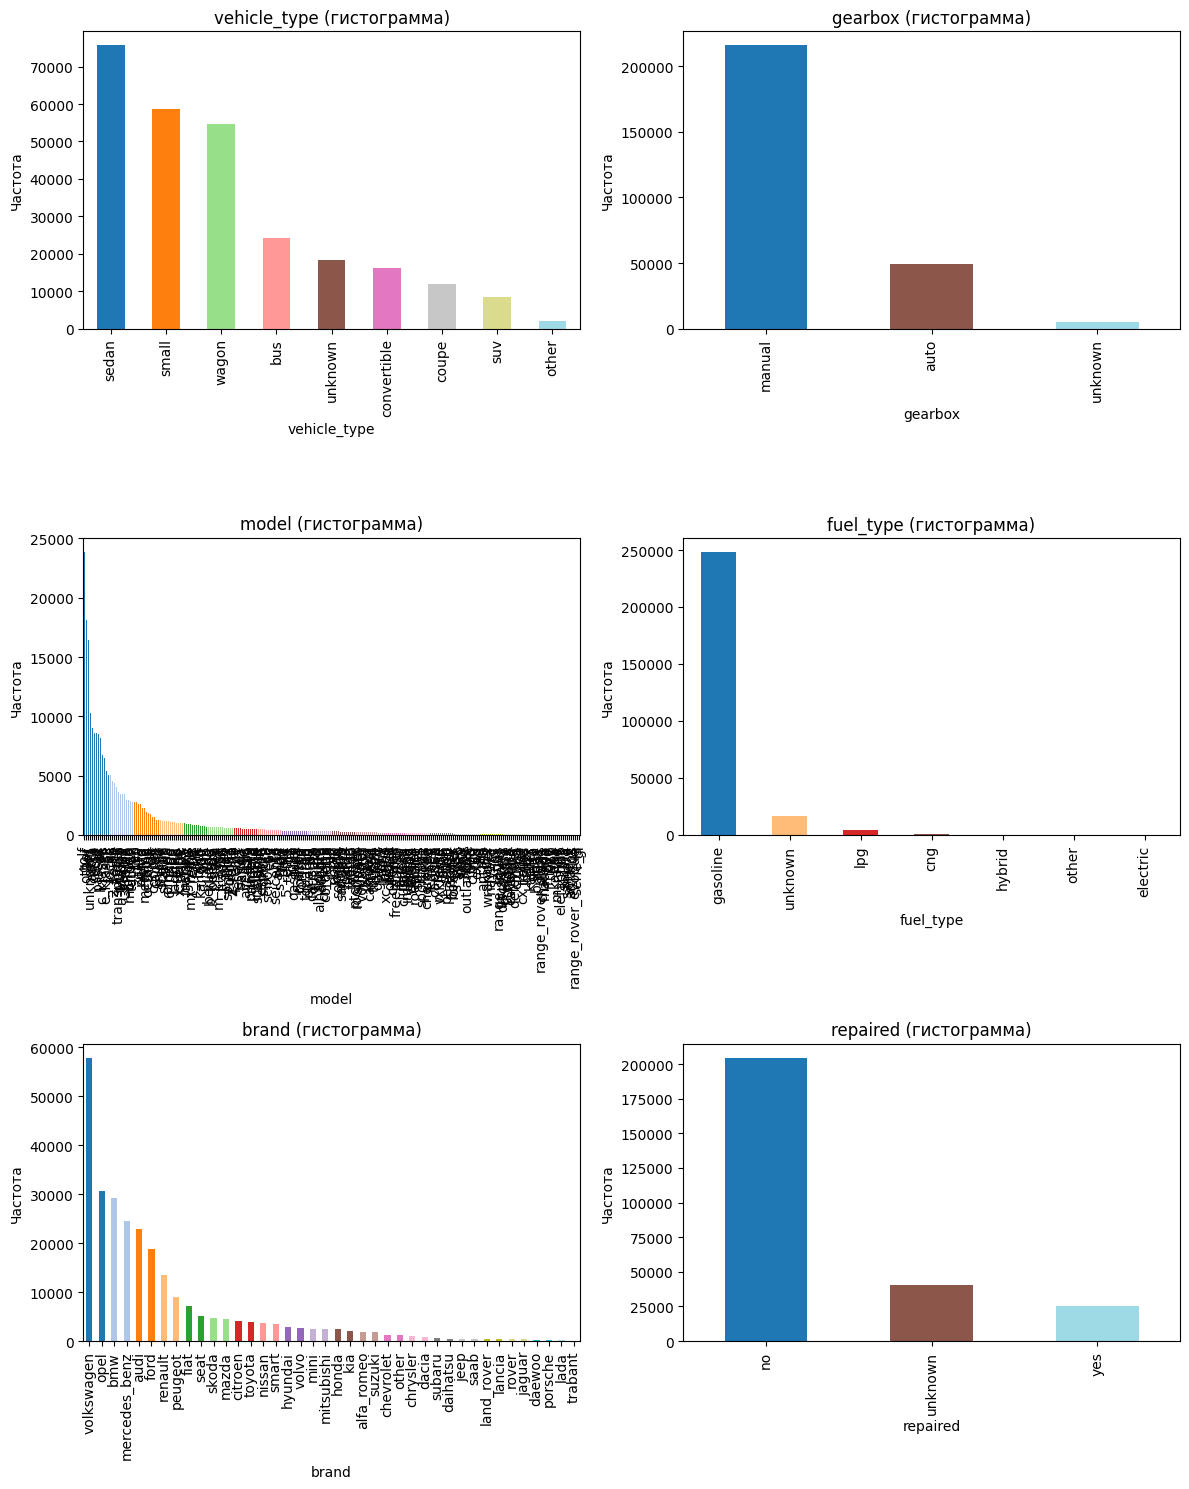

In [69]:
plot_categorical_columns(df, col=None, target=None)

Ну вот и ладненько

## Кореляция

interval columns not set, guessing: ['registration_year', 'power', 'kilometer']


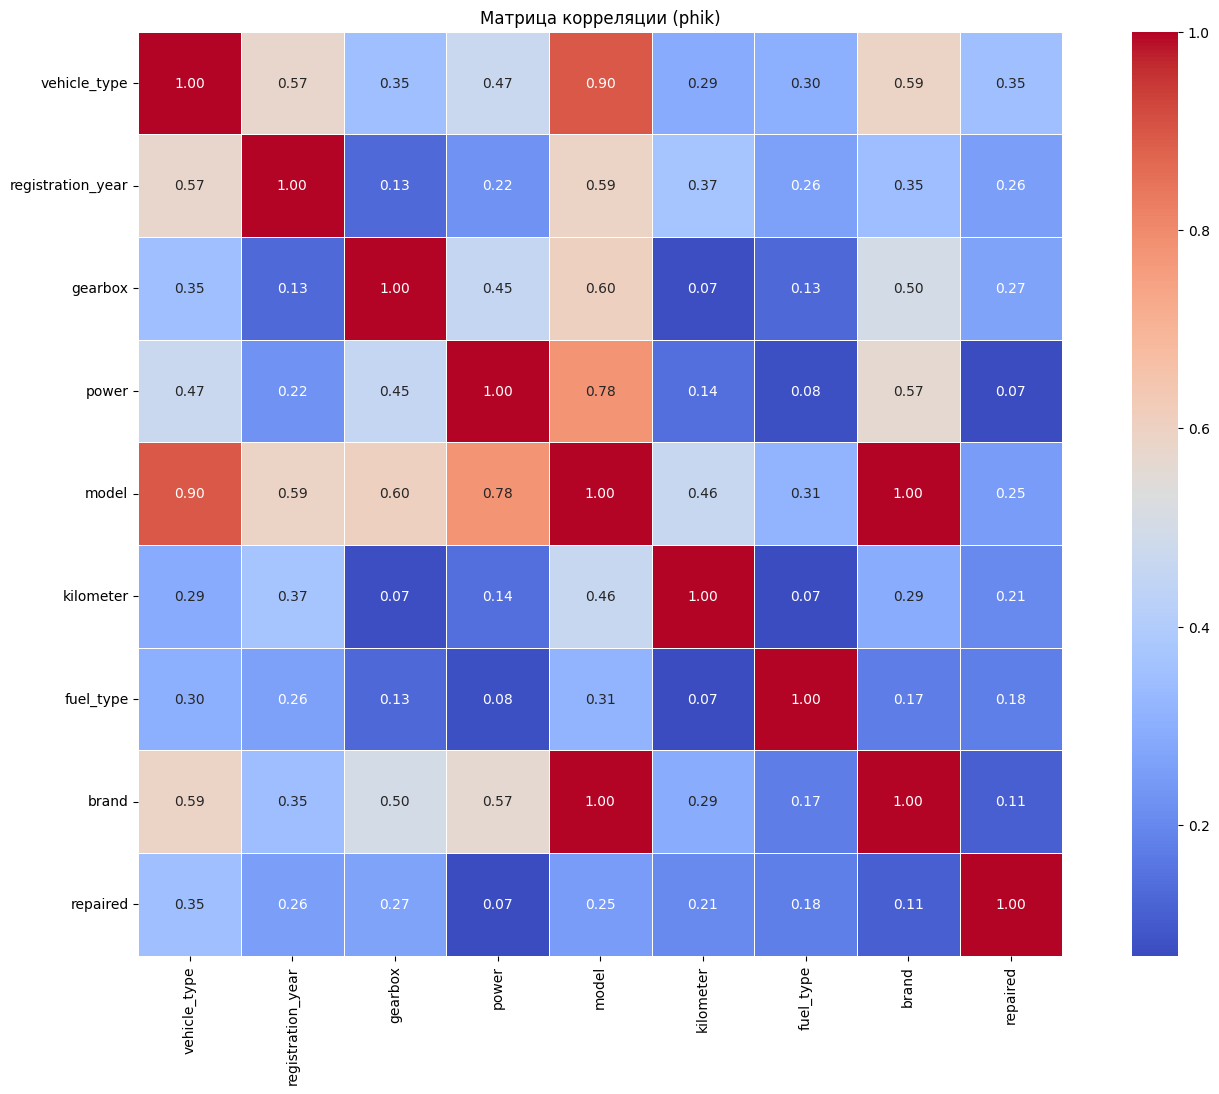

In [70]:
cor = df.drop(columns=['price'])
correlation_matrix = cor.phik_matrix()

plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            square=True, 
            linecolor='white',
            linewidths=0.5)
plt.title('Матрица корреляции (phik)')
plt.show()

Видим кореляцию в 1 между брендом и моделью  
Нам интересно оставить там где больше уникальных значений - это модель  
Бренд - удаляем

In [71]:
need_cols = ["price", "vehicle_type", "registration_year", "gearbox", "power", "model", "kilometer", "fuel_type", "repaired"]
df = df[need_cols]

In [72]:
# и шлифанем удалением явных дубликатов
len_before = df.shape[0]
df = drop_duplicated(df)
len_after = df.shape[0]
duplicates = (len_before - len_after) / len_before * 100
display(f"Удалено {len_before - len_after} строк ({duplicates:.2f}%) из {len_before}")

np.int64(36780)

'Удаляем'

'Удалено 36780 строк (13.60%) из 270379'

'=== Корреляция с таргетом ==='

power                0.420914
registration_year    0.420814
kilometer           -0.339935
repaired            -0.257185
gearbox             -0.183546
fuel_type           -0.110315
vehicle_type        -0.087666
model               -0.038209
Name: price, dtype: float64

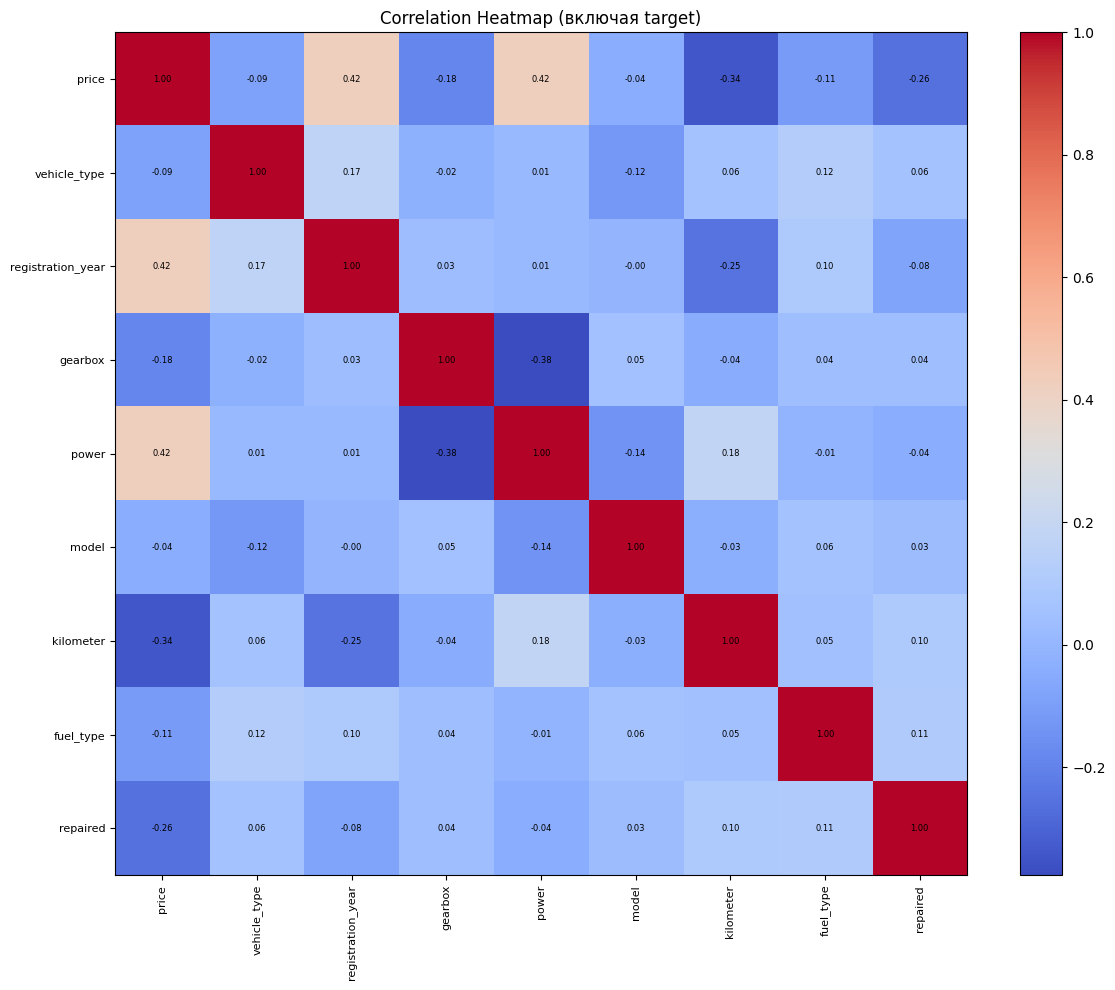

'=== VIF ==='

,feature,VIF
2,gearbox,1.268226
3,power,1.256993
5,kilometer,1.187622
1,registration_year,1.135770
7,repaired,1.102889
6,fuel_type,1.082127
0,vehicle_type,1.080744
4,model,1.039731


In [73]:
# на последок еще разок все проверим
calc_target_correlations(df, target_col="price")

Теперь все отлично.  
Данные готовы к обучению.

## Выводы

1) Пропуски:  
В базе есть ряд пропусков в столбцах vehicletype, gearbox, model, fueltype и repaired - заменим на unknown

2) Было 4 полных дубликата - их мы удалили вначале, после всех обработок удалили еще 37244, что составило 13% от всей таблицы, что в целом сойдет

3) Признаки:  
Выделили признаки которые влияют на цену - VehicleType, RegistrationYear, Gearbox, Power, Model, Kilometer, FuelType, Brand, Repaired  
И не влияют на цену - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen  
Последние в расчеты не брались.  
Возмонжо региональность размещения автомобиля и будет влиять на цену, но конкретно здесь это регион автора объявления, а авто может быть использовался в другом регионе, поэтому не будем его использовать.  

4) Правки признаков:  
Скорректировали год выпуска - теперь границы между 1960 и настоящим годом;  
Скорректировали мощность - теперь она от 54 до 300 лошадей;  
В типе кузова, типе топлива и бренде - все пропуски изменили на unknown, для единообразия;  


## Обучение моделей

### Подготовим данные для обучения

#### Разбивка исходной базы

In [74]:
# возьмем часть данных для финальной проверки
df_test = df.sample(frac=0.05, random_state=RANDOM_STATE)
df_rest = df.drop(df_test.index)  # остальное пойдет на train/val/test

In [75]:
# разделим на выборки из оставшихся данных
X_train, X_val, y_train, y_val = train_test_split(
    df_rest.drop(['price'], axis=1),
    df_rest['price'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# финальный отложенный тест
X_final_test = df_test.drop(['price'], axis=1)
y_final_test = df_test['price']

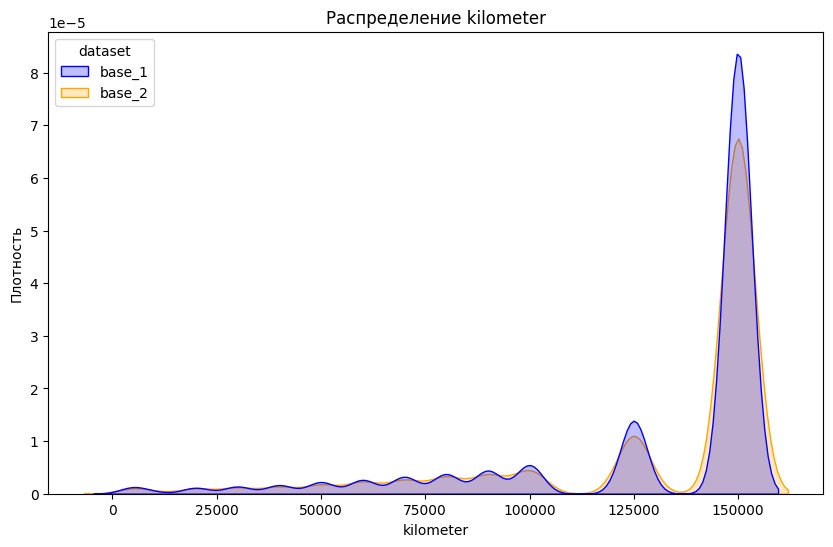

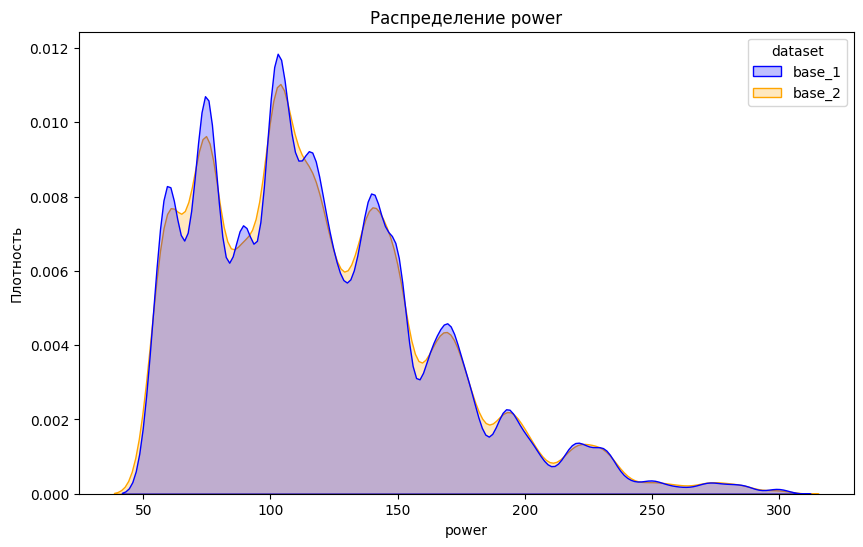

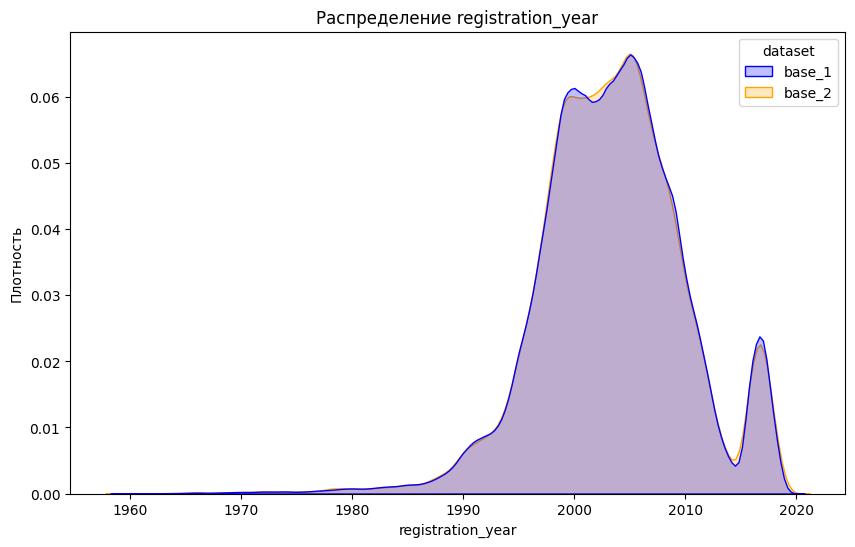

In [76]:
analyze_data([X_train, X_val], ['price'])

Данные разбились равномерно, все красиво.

#### Подготовка к обучению

In [77]:
# сюда будем писать результаты
results = {}

In [78]:
# # Разделяем признаки
cat_selector = make_column_selector(dtype_include=["object", "category"])
num_selector = make_column_selector(dtype_exclude=["object", "category"])

# # Дальше разделение на one-hot и ordinal исходя из объема уникальных значений, иначе может отвалится по памяти
# onehot_cols = [col for col in categorical_cols if X_train[col].nunique() <= 15]
# ordinal_cols = [col for col in categorical_cols if X_train[col].nunique() > 15]

In [79]:
to_str = FunctionTransformer(lambda x: x.astype(str))

# для линейных моделей
preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", StandardScaler())
        ]), num_selector),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))
        ]), cat_selector)
    ]
)

# для деревьев и бустингов
preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_selector),
        ("cat", Pipeline([
            ("to_str", to_str),
            ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_selector)
    ]
)

In [80]:
models = {
    "LinearRegression": (lambda: LinearRegression(), preprocessor_linear),
    "RandomForest": (lambda: RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS), preprocessor_tree),
    "DecisionTree": (lambda: DecisionTreeRegressor(random_state=RANDOM_STATE), preprocessor_tree),
    "LightGBM": (lambda: LGBMRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=-1), preprocessor_tree),
    "XGBoost": (lambda: XGBRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS, verbosity=0), preprocessor_tree),
    "CatBoost": (lambda: CatBoostRegressor(random_state=RANDOM_STATE, task_type="CPU", thread_count=N_JOBS, verbose=0), preprocessor_tree),
}

In [81]:
param_grids = {
    "LinearRegression": {
        "model__fit_intercept": [True, False],
    },

    "DecisionTree": {
        "model__criterion": ["squared_error"],
        "model__max_depth": randint(4, 10),
        "model__min_samples_split": randint(2, 10),
        "model__min_samples_leaf": randint(2, 5),
        "model__max_features": ["sqrt", "log2"],
    },

    "RandomForest": {
        "model__n_estimators": randint(20, 50),
        "model__max_depth": randint(4, 10),
        "model__min_samples_split": randint(2, 10),
        "model__min_samples_leaf": randint(2, 5),
        "model__max_features": ["sqrt", "log2"],
        "model__bootstrap": [True],
    },

    "LightGBM": {
        "model__num_leaves": randint(50, 255),
        "model__max_depth": randint(5, 15),
        "model__learning_rate": uniform(0.01, 0.3),
        "model__n_estimators": randint(100, 150),
        "model__subsample": uniform(0.6, 0.4),
        "model__colsample_bytree": uniform(0.6, 0.4),
        "model__reg_alpha": uniform(0.0, 1.0),
        "model__reg_lambda": uniform(0.0, 1.0),
        "model__min_child_samples": randint(10, 50),
    },

    "XGBoost": {
        "model__n_estimators": randint(100, 200),
        "model__max_depth": randint(3, 12),
        "model__learning_rate": uniform(0.01, 0.3),
        "model__subsample": uniform(0.6, 0.4),
        "model__colsample_bytree": uniform(0.6, 0.4),
        "model__gamma": uniform(0.0, 5.0),
        "model__min_child_weight": randint(1, 10),
        "model__reg_alpha": uniform(0.0, 1.0),
        "model__reg_lambda": uniform(0.0, 1.0),
    },

    "CatBoost": {
        "model__iterations": randint(100, 300),
        "model__depth": randint(3, 10),
        "model__learning_rate": uniform(0.01, 0.3),
        "model__l2_leaf_reg": uniform(1.0, 5.0),
        "model__border_count": randint(32, 255),
        "model__bagging_temperature": uniform(0.0, 1.0),
        "model__random_strength": uniform(0.0, 1.0),
    },
}

In [82]:
def bootstrap_rmse(y_true, y_pred, n_bootstrap=500, random_state=RANDOM_STATE):
    np.random.seed(random_state)
    scores = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        y_true_bs = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_pred_bs = y_pred.iloc[indices] if hasattr(y_pred, 'iloc') else y_pred[indices]
        scores.append(root_mean_squared_error(y_true_bs, y_pred_bs))
    return np.percentile(scores, 2.5), np.percentile(scores, 97.5)

### Обучение

In [83]:
all_rows = []
final_rows = []
best_models = {}  # Будем сохранять лучшие модели

for name, (model_factory, preprocessor) in tqdm(models.items(), desc="Модели", leave=True):
    
    # Создаем пайплайн
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model_factory())
    ])
    
    # Настраиваем RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grids[name],
        n_iter=N_ITER,
        cv=KFold(n_splits=N_CROSS_VALL, shuffle=True, random_state=RANDOM_STATE),
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        return_train_score=True
    )
    
    # Обучение с замером времени
    time_start = time.perf_counter()
    search.fit(X_train, y_train)
    time_fit = time.perf_counter() - time_start
    
    # Сохраняем лучшую модель
    best_models[name] = search.best_estimator_
    
    # Предсказание на валидационной выборке
    time_start = time.perf_counter()
    preds_val = best_models[name].predict(X_val)
    time_predict = time.perf_counter() - time_start
    
    # Расчет метрик
    rmse_val = root_mean_squared_error(y_val, preds_val)
    rmse_min, rmse_max = bootstrap_rmse(y_val, preds_val)
    
    # Сохранение результатов
    final_rows.append({
        "Model": name,
        "Best_params": search.best_params_,
        "RMSE_CV": -search.best_score_,  # преобразуем обратно из neg_rmse
        "Time_fit": time_fit,
        "Time_predict": time_predict,
        "RMSE_val": rmse_val,
        "RMSE_val_min": rmse_min,
        "RMSE_val_max": rmse_max
    })
    
    # Сохранение всех итераций для анализа
    for i, (params, mean_score, std_score) in enumerate(zip(
        search.cv_results_['params'],
        search.cv_results_['mean_test_score'],
        search.cv_results_['std_test_score']
    )):
        all_rows.append({
            "Model": name,
            "Params": params,
            "RMSE_CV": -mean_score,  # преобразуем обратно
            "RMSE_CV_std": std_score,
            "Iteration": i
        })

results_df = pd.DataFrame(all_rows)
final_df = pd.DataFrame(final_rows)

Модели: 100%|██████████| 6/6 [00:46<00:00,  7.83s/it]


### Выводы

Для обучения и сравнения были взяты следующие модели:  
1) LinearRegression;  
2) RandomForest;  
3) DecisionTree;  
4) LightGBM;  
5) XGBoost;  
6) CatBoost;  

Для каждой модели была подготовлена сетка параметров, который перебирались с помощью randomgreedsearch с целью поиска наилучших параметров для каждой конкретной модели.

# Анализ моделей

In [84]:
# выбираем по одной лучшей конфигурации для каждой модели по RMSE_CV
best_cv = results_df.loc[
    results_df.groupby("Model")["RMSE_CV"].idxmin()
].reset_index(drop=True)

# объединяем лучшие параметры с финальными замерами времени и валидационной метрикой
best_model = best_cv.merge(
    final_df.drop(columns=["RMSE_CV"]),
    on=["Model"],
    how="left"
)

# считаем доверительный интервал (дельту) по валидационной метрике
best_model["RMSE_val_delta"] = (best_model["RMSE_val_max"] - best_model["RMSE_val_min"]) / 2

# проверка на финальном отложенном тесте
final_rmse = []
for name in models.keys():
    # Используем сохраненную лучшую модель
    pipe = best_models[name]
    
    preds_final = pipe.predict(X_final_test)
    rmse_final = root_mean_squared_error(y_final_test, preds_final)
    final_rmse.append({"Model": name, "RMSE_final_holdout": rmse_final})

best_model = best_model.merge(pd.DataFrame(final_rmse), on="Model", how="left")

# сортируем по качеству CV
best_model = best_model.sort_values(by="RMSE_CV", ascending=True).reset_index(drop=True)

display(best_model.T)

,0,1,2,3,4,5
Model,LightGBM,XGBoost,CatBoost,RandomForest,DecisionTree,LinearRegression
Params,{'model__colsample_bytree': 0.7442246226804569...,{'model__colsample_bytree': 0.9496787025363427...,{'model__bagging_temperature': 0.7830036094590...,"{'model__bootstrap': True, 'model__max_depth':...","{'model__criterion': 'squared_error', 'model__...",{'model__fit_intercept': True}
RMSE_CV,1395.113509,1397.393392,1467.521993,1705.710465,1944.773826,2156.687284
RMSE_CV_std,5.528015,4.039154,2.444191,5.044644,58.667001,5.111603
Iteration,9,3,2,7,6,0
Best_params,{'model__colsample_bytree': 0.7442246226804569...,{'model__colsample_bytree': 0.9496787025363427...,{'model__bagging_temperature': 0.7830036094590...,"{'model__bootstrap': True, 'model__max_depth':...","{'model__criterion': 'squared_error', 'model__...",{'model__fit_intercept': True}
Time_fit,16.198859,5.638063,13.393795,3.988843,1.697483,3.24336
Time_predict,0.066612,0.057074,0.090728,0.04962,0.033633,0.044876
RMSE_val,1394.135395,1400.057129,1476.215179,1718.275062,1982.84805,2180.471433
RMSE_val_min,1375.401646,1382.988712,1459.330926,1701.058111,1962.841258,2157.637762


После обучения мы получили словарь результатов по каждой из моделей, среди которых были отобраны лучшие представители по каждой из них, где итоговая таблица была отсортирована по увеличению ключевой метрики обучения.  

# Выводы

Исходя из комплексного анализа:  
1) LightGBM демонстрирует наилучшее качество как на кросс-валидации (1395), так и на финальном тесте (1417), с минимальным переобучением (+1.6%)  
2) XGBoost показывает сопоставимое качество (разница всего 0.16%) при значительно лучшей производительности:  
- В 2.9 раза быстрее обучается;  
- На 17% быстрее предсказывает;  
- Более стабильные результаты по std на CV (4.04 vs 5.53);  
3) CatBoost уступает лидерам по качеству (+5.2% к RMSE), но показывает наилучшую стабильность  
4) RandomForest может рассматриваться как компромиссный вариант для интерпретируемости  

Рекомендация:  
1) LightGBM - оптимальный выбор для внедрения, так как:  
- Показывает наилучшее итоговое качество на независимом тесте  
- Имеет минимальное переобучение  
- Разница в скорости предсказания не критична для production  
2) XGBoost - лучшая альтернатива при жестких требованиях к:  
- Скорости обучения (в 3 раза быстрее)  
- Производительности инференса  
- Стабильности результатов  

Обе модели значительно превосходят требуемое качество (RMSE < 2500) и могут быть успешно внедрены в production.  

# Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей